## Building Models to Predict the Prospective Customers

By Jiawei Ren;

Enviroment: Python 3+ and PySpark 3.0.0 

### Dataset :
* bureau.csv
* customer.csv
* A Metadata file is included which contains the information about the dataset.    
（https://www.kaggle.com/datasets/rizdelhi/analytics-vidya-ltfs-finhack-3?select=ltfs3_train_bureau.csv）

### Table of Content:

* [1. Data Preparation and Exploration](#task1)
    * [1.1 Creating Spark Session](#task11)
    * [1.2 Loading the Data](#task12)
    * [1.3 Exploring the data](#task13)
* [2. Feature extraction and ML training ](#task2)
    * [2.1 Preparing the training data and testing data](#task21)
    * [2.2 Preparing Features, Labels, and Models](#task22)
    * [2.3 Training and evaluating models](#task23)
* [3. Knowledge sharing](#task3)



## Part1. Data Preparation and Exploration  <a class="anchor" id="task1"></a>

### 1.1 Creating Spark Session <a class="anchor" id="task11"></a>


In [1]:
# Import SparkConf, sparkcontext, sparksession class into program
from pyspark import SparkConf
from pyspark.sql import SparkSession # Spark SQL
import pandas as pd

#1. Create a SparkConf object for using as many local cores as possible for a proper application name
master = "local[*]"
app_name = "ass2a"
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

#2. Then create a SparkSession using the SparkConf object.
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()

### 1.2 Loading the Data <a class="anchor" id="task12"></a>

In [2]:
#define schema for customer_Dataframe
#'BranchID', 'AssetID', 'ManufacturerID', and 'SupplierID' be read as String types. 
#schema information is from the metadata file 
from pyspark.sql.types import StructType,StringType, IntegerType,DoubleType,TimestampType,StructField
schm = StructType([ \
    StructField("ID",StringType(),True), \
    StructField("Frequency",StringType(),True), \
    StructField("InstlmentMode",StringType(),True), \
    StructField("LoanStatus", StringType(), True), \
    StructField("PaymentMode", StringType(), True), \
    StructField("BranchID", StringType(), True), \
    StructField("Area",StringType(),True), \
    StructField("Tenure",IntegerType(),True), \
    StructField("AssetCost",IntegerType(),True), \
    StructField("AmountFinance",DoubleType(),True), \
    StructField("DisbursalAmount",DoubleType(),True), \
    StructField("EMI",DoubleType(),True), \
    StructField("DisbursalDate",TimestampType(),True), \
    StructField("MaturityDAte",TimestampType(),True), \
    StructField("AuthDate",TimestampType(),True), \
    StructField("AssetID",StringType(),True), \
    StructField("ManufacturerID",StringType(),True), \
    StructField("SupplierID",StringType(),True), \
    StructField("LTV",DoubleType(),True), \
    StructField("SEX",StringType(),True), \
    StructField("AGE",IntegerType(),True), \
    StructField("MonthlyIncome",DoubleType(),True), \
    StructField("City",StringType(),True), \
    StructField("State",StringType(),True), \
    StructField("ZiPCODE",StringType(),True), \
    StructField("Top-up Month",StringType(),True) \
  ])

In [3]:
#1. Load each data file into two separate Spark dataframes
#For the Bureau data, use PySpark to auto-identify the column types
bureau_Dataframe = spark.read.csv("data//bureau.csv",header=True,inferSchema=True)
customer_Dataframe = spark.read.csv("data//customer.csv",header=True,schema =schm)
# bureau_Dataframe.createOrReplaceTempView("bureau_Dataframe")
# customer_Dataframe.createOrReplaceTempView("customer_Dataframe")
#print out the row count and schema of each dataframe.
print('bureau_Dataframe row count:',bureau_Dataframe.count(),'\n')
print('bureau_Dataframe schema:')
bureau_Dataframe.printSchema()

print('customer_Dataframe row count:', customer_Dataframe.count(),'\n')
print('customer_Dataframe schema:')
customer_Dataframe.printSchema()



bureau_Dataframe row count: 624863 

bureau_Dataframe schema:
root
 |-- ID: integer (nullable = true)
 |-- SELF-INDICATOR: boolean (nullable = true)
 |-- MATCH-TYPE: string (nullable = true)
 |-- ACCT-TYPE: string (nullable = true)
 |-- CONTRIBUTOR-TYPE: string (nullable = true)
 |-- DATE-REPORTED: timestamp (nullable = true)
 |-- OWNERSHIP-IND: string (nullable = true)
 |-- ACCOUNT-STATUS: string (nullable = true)
 |-- DISBURSED-DT: timestamp (nullable = true)
 |-- CLOSE-DT: timestamp (nullable = true)
 |-- LAST-PAYMENT-DATE: timestamp (nullable = true)
 |-- CREDIT-LIMIT/SANC AMT: string (nullable = true)
 |-- DISBURSED-AMT/HIGH CREDIT: string (nullable = true)
 |-- INSTALLMENT-AMT: string (nullable = true)
 |-- CURRENT-BAL: string (nullable = true)
 |-- INSTALLMENT-FREQUENCY: string (nullable = true)
 |-- OVERDUE-AMT: string (nullable = true)
 |-- WRITE-OFF-AMT: integer (nullable = true)
 |-- ASSET_CLASS: string (nullable = true)
 |-- REPORTED DATE - HIST: string (nullable = true)
 |

In [4]:
from pyspark.sql.functions import *
#2. For the Bureau dataframe, convert all string columns containing ',' to numeric columns
cols=['CREDIT-LIMIT/SANC AMT','DISBURSED-AMT/HIGH CREDIT','INSTALLMENT-AMT','CURRENT-BAL','OVERDUE-AMT']
bureau_Dataframe[cols].show(6)


+---------------------+-------------------------+---------------+-----------+-----------+
|CREDIT-LIMIT/SANC AMT|DISBURSED-AMT/HIGH CREDIT|INSTALLMENT-AMT|CURRENT-BAL|OVERDUE-AMT|
+---------------------+-------------------------+---------------+-----------+-----------+
|                 null|                   44,000|  1,405/Monthly|     20,797|       null|
|                 null|                   37,352|           null|     37,873|     37,873|
|                 null|                 4,00,000|           null|          0|          0|
|                 null|                 5,00,000|           null|          0|          0|
|                 null|                 1,45,000|           null|   1,16,087|          0|
|               50,000|                        0|           null|          0|       null|
+---------------------+-------------------------+---------------+-----------+-----------+
only showing top 6 rows



In [5]:
# Transform column INSTALLMENT-AMT eg. 1,405/Monthly -> 1405
#split by '/' and get the numeric part only
bureau_Dataframe = bureau_Dataframe.withColumn("INSTALLMENT-AMT", 
    split(bureau_Dataframe['INSTALLMENT-AMT'],'/').getItem(0))
# remove ','
bureau_Dataframe = bureau_Dataframe.withColumn("INSTALLMENT-AMT", 
    regexp_replace(bureau_Dataframe['INSTALLMENT-AMT'],',',''))

In [6]:
# remove ',' for the rest of columns
colss=['CREDIT-LIMIT/SANC AMT','DISBURSED-AMT/HIGH CREDIT','CURRENT-BAL','OVERDUE-AMT']
for i in range(len(colss)):
    bureau_Dataframe = bureau_Dataframe.withColumn(colss[i], 
        regexp_replace(bureau_Dataframe[colss[i]],',',''))
bureau_Dataframe[cols].show(6)

+---------------------+-------------------------+---------------+-----------+-----------+
|CREDIT-LIMIT/SANC AMT|DISBURSED-AMT/HIGH CREDIT|INSTALLMENT-AMT|CURRENT-BAL|OVERDUE-AMT|
+---------------------+-------------------------+---------------+-----------+-----------+
|                 null|                    44000|           1405|      20797|       null|
|                 null|                    37352|           null|      37873|      37873|
|                 null|                   400000|           null|          0|          0|
|                 null|                   500000|           null|          0|          0|
|                 null|                   145000|           null|     116087|          0|
|                50000|                        0|           null|          0|       null|
+---------------------+-------------------------+---------------+-----------+-----------+
only showing top 6 rows



In [7]:
#3. Show how many rows contain a null value in the Customer dataframe,
#row count before remove rows that has null value
row_before = customer_Dataframe.count()
# remove all rows which contain any null value.
customer_Dataframe=customer_Dataframe.na.drop()
#row count after remove rows that has null value
row_after = customer_Dataframe.count()
print('number of rows that has null value: ',row_before- row_after)

number of rows that has null value:  22092


In [8]:
#4. Show the null percentage of all columns in the Bureau dataframe
base = bureau_Dataframe.count()
df_na_percent = bureau_Dataframe.select([(count(when(col(c).isNull(), c))/base).alias(c) for c in bureau_Dataframe.columns]
   )

# find columns whose percentage of null is larger than 20% 
percentage = 0.2
# get null percentage
rates = df_na_percent.collect()[0]
for c in bureau_Dataframe.columns:
   # find columns whose percentage of null is larger than 20% 
   if (df_na_percent.select(c).collect()[0])[0] > percentage :
      bureau_Dataframe = bureau_Dataframe.drop(c)
df_na_percent.toPandas().head()


,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,...,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE
0,0.0,0.0,0.0,0.0,0.0,0.005894,0.0,0.0,0.051522,0.453237,...,0.757571,0.211275,0.034702,0.536562,0.034702,0.035547,0.034702,0.034702,0.036754,0.657727


In [9]:
#5. 

for c in bureau_Dataframe.columns:
# Remove all columns containing 'HIST’ in the columns’ names for the bureau dataframe
    if "HIST" in c:
        bureau_Dataframe = bureau_Dataframe.drop(c)
#and all columns related to ‘time’ (the columns’ names contained “DATE” or “DT”) in the bureau dataframe, 
    if ("DATE" in c) or ("DT" in c):
        bureau_Dataframe = bureau_Dataframe.drop(c)
bureau_Dataframe.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- SELF-INDICATOR: boolean (nullable = true)
 |-- MATCH-TYPE: string (nullable = true)
 |-- ACCT-TYPE: string (nullable = true)
 |-- CONTRIBUTOR-TYPE: string (nullable = true)
 |-- OWNERSHIP-IND: string (nullable = true)
 |-- ACCOUNT-STATUS: string (nullable = true)
 |-- DISBURSED-AMT/HIGH CREDIT: string (nullable = true)
 |-- CURRENT-BAL: string (nullable = true)
 |-- WRITE-OFF-AMT: integer (nullable = true)



In [10]:
bureau_Dataframe.toPandas().head()

,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-AMT/HIGH CREDIT,CURRENT-BAL,WRITE-OFF-AMT
0,1,False,PRIMARY,Auto Loan (Personal),NAB,Individual,Active,44000,20797,0.0
1,1,False,PRIMARY,Overdraft,NAB,Individual,Delinquent,37352,37873,0.0
2,1,True,PRIMARY,Auto Loan (Personal),NBF,Individual,Closed,400000,0,0.0
3,1,True,PRIMARY,Auto Loan (Personal),NBF,Individual,Closed,500000,0,0.0
4,1,True,PRIMARY,Tractor Loan,NBF,Individual,Active,145000,116087,0.0


### 1.3 Exploring the data <a class="anchor" id="task13"></a>

In [11]:
# 1. For each numeric feature in each activity, show the basic statistics (including count, mean, std dev, min, max)
#bureau_Dataframe：
bureau_Dataframe= bureau_Dataframe.withColumn("DISBURSED-AMT/HIGH CREDIT",col('DISBURSED-AMT/HIGH CREDIT').cast(IntegerType()))
bureau_Dataframe = bureau_Dataframe.withColumn("CURRENT-BAL",col('CURRENT-BAL').cast(IntegerType()))
bureau_Dataframe = bureau_Dataframe.withColumn("WRITE-OFF-AMT",col('WRITE-OFF-AMT').cast(DoubleType()))

bureau_Dataframe.select('DISBURSED-AMT/HIGH CREDIT','CURRENT-BAL', 'WRITE-OFF-AMT').describe().toPandas().head()

,summary,DISBURSED-AMT/HIGH CREDIT,CURRENT-BAL,WRITE-OFF-AMT
0,count,624825,624598,603179
1,mean,316589.3861433201,103717.07101207497,291.3442643062839
2,stddev,5176936.446701582,851087.5975786751,19561.752315897815
3,min,-83878,-20868956,-30.0
4,max,999999999,375991329,8797356.0


In [12]:
# customer_Dataframe：
#get numeric type column
int_type = customer_Dataframe[[item[0] for item in customer_Dataframe.dtypes if item[1].startswith('int')]].columns
double_type = customer_Dataframe[[item[0] for item in customer_Dataframe.dtypes if item[1].startswith('double')]].columns
numeric_type = int_type + double_type
customer_Dataframe.select(*numeric_type).describe().toPandas().head()


,summary,Tenure,AssetCost,AGE,AmountFinance,DisbursalAmount,EMI,LTV,MonthlyIncome
0,count,121308,121308,121308,121308,121308,121308,121308,121308
1,mean,42.75597652257065,563289.852482936,40.70355623701652,356361.52626380784,356002.3838225838,56821.71514731098,59.62412924127006,51901.613624658035
2,stddev,22.433473986085676,103558.845010007,11.794657218312981,105717.74807158226,105537.25852397796,28585.22968535343,15.818416557893888,1774582.5522165147
3,min,5,200000,18,50000.0,2894.0,200.0,-1.38,0.0
4,max,501,2250000,90,1308351.0,1308351.0,460000.0,100.0,6.174775E8


In [13]:
#for each non-numeric feature in each activity, display the top-10 values and the corresponding counts
#bureau_Dataframe：
str_type = bureau_Dataframe[[item[0] for item in bureau_Dataframe.dtypes if item[1].startswith('str')]].columns
for i in range(len(str_type)):
    bureau_Dataframe.groupBy(str_type[i]).count().sort(col("count").desc()).show(10)


+----------+------+
|MATCH-TYPE| count|
+----------+------+
|   PRIMARY|624638|
| SECONDARY|   225|
+----------+------+

+--------------------+------+
|           ACCT-TYPE| count|
+--------------------+------+
|        Tractor Loan|208051|
|           Gold Loan| 98602|
|Business Loan Pri...| 88274|
|   Kisan Credit Card| 37621|
|Auto Loan (Personal)| 33504|
|               Other| 31729|
|Commercial Vehicl...| 21296|
|    Two-Wheeler Loan| 17656|
|         Credit Card| 14397|
|       Consumer Loan| 13769|
+--------------------+------+
only showing top 10 rows

+----------------+------+
|CONTRIBUTOR-TYPE| count|
+----------------+------+
|             NBF|286311|
|             NAB|191368|
|             PRB| 84392|
|             COP| 26853|
|             RRB| 26374|
|             MFI|  3676|
|             HFC|  3174|
|             CCC|  1651|
|             FRB|   813|
|             SFB|   239|
+----------------+------+
only showing top 10 rows

+----------------+------+
|   OWNERSHIP-IND

In [14]:
# customer_Dataframe：
str_type = customer_Dataframe[[item[0] for item in customer_Dataframe.dtypes if item[1].startswith('str')]].columns
timestamp_type = customer_Dataframe[[item[0] for item in customer_Dataframe.dtypes if item[1].startswith('time')]].columns
nnumeric = str_type+timestamp_type
nnumeric.remove('Top-up Month')
nnumeric.remove('ID')
for i in range(len(nnumeric)):
    customer_Dataframe.groupBy(nnumeric[i]).count().sort(col("count").desc()).show(10)

+-----------+-----+
|  Frequency|count|
+-----------+-----+
|Half Yearly|78986|
|    Monthly|22535|
|    Quatrly|19482|
| BI-Monthly|  305|
+-----------+-----+

+-------------+------+
|InstlmentMode| count|
+-------------+------+
|       Arrear|116999|
|      Advance|  4309|
+-------------+------+

+----------+-----+
|LoanStatus|count|
+----------+-----+
|    Closed|86260|
|    Active|35048|
+----------+-----+

+------------+-----+
| PaymentMode|count|
+------------+-----+
|         ECS|33078|
|Direct Debit|32545|
|         PDC|25951|
|      Billed|17668|
|       PDC_E| 9398|
|  Auto Debit|  905|
|   SI Reject|  803|
|      Cheque|  489|
|  ECS Reject|  457|
|  PDC Reject|    7|
+------------+-----+
only showing top 10 rows

+--------+-----+
|BranchID|count|
+--------+-----+
|      24| 4534|
|     199| 4391|
|     166| 2464|
|      50| 2348|
|     202| 2234|
|     263| 2154|
|      41| 1935|
|     246| 1934|
|      85| 1854|
|     133| 1837|
+--------+-----+
only showing top 10 rows

+

In [15]:
#Give proper column name to the bureau dataframe eg. change "-" to "_"
for i in range(len(bureau_Dataframe.columns)):
    if "-" in bureau_Dataframe.columns[i]:
        newname = bureau_Dataframe.columns[i].replace("-","_")
        bureau_Dataframe = bureau_Dataframe.withColumnRenamed(bureau_Dataframe.columns[i],newname)
bureau_Dataframe = bureau_Dataframe.withColumnRenamed("DISBURSED_AMT/HIGH CREDIT","DISBURSED_AMT_HIGH_CREDIT")

In [16]:
#create sql tempview
bureau_Dataframe.createOrReplaceTempView("bureau_Dataframe")

In [17]:
#2. Merged rows in the Bureau dataframe by 'ID’
# by sum the rows for numeric type columns, count distinct values for other columns with other data types
# rename them with the postfix like '_sum' or '_dist
sql_count = spark.sql('''
  SELECT
    ID,
    count(distinct(SELF_INDICATOR)) AS SELF_INDICATOR_dist,
    count(distinct(MATCH_TYPE)) AS MATCH_TYPE_dist,
    count(distinct(ACCT_TYPE)) AS ACCT_TYPE_dist,
    count(distinct(CONTRIBUTOR_TYPE)) AS CONTRIBUTOR_TYPE_dist,
    count(distinct(OWNERSHIP_IND)) AS OWNERSHIP_IND_dist,
    count(distinct(ACCOUNT_STATUS)) AS ACCOUNT_STATUS_dist,
    SUM(DISBURSED_AMT_HIGH_CREDIT) AS DISBURSED_AMT_HIGH_CREDIT_sum,
    SUM(CURRENT_BAL) AS CURRENT_BAL_sum,
    SUM(WRITE_OFF_AMT) AS WRITE_OFF_AMT_sum
  FROM bureau_Dataframe
  GROUP BY ID
  ORDER BY ID ASC;
''')
sql_count.toPandas().head(10)

,ID,SELF_INDICATOR_dist,MATCH_TYPE_dist,ACCT_TYPE_dist,CONTRIBUTOR_TYPE_dist,OWNERSHIP_IND_dist,ACCOUNT_STATUS_dist,DISBURSED_AMT_HIGH_CREDIT_sum,CURRENT_BAL_sum,WRITE_OFF_AMT_sum
0,1,2,1,4,2,1,3,2201352,618526,0.0
1,2,2,1,7,2,2,2,18117081,10349457,0.0
2,3,2,1,8,5,3,3,3708369,2065165,0.0
3,4,2,1,4,3,2,2,2964588,2191274,0.0
4,5,2,1,5,4,2,2,1939813,907231,0.0
5,6,2,1,4,2,3,2,3237361,102800,0.0
6,7,2,1,2,1,1,2,1272553,624000,0.0
7,8,2,1,3,3,3,4,2025216,974119,0.0
8,9,1,1,1,1,1,1,280000,0,0.0
9,10,2,1,2,1,2,2,1164268,283723,0.0


In [18]:
# create sql tempview
sql_count.createOrReplaceTempView("sql_count")
customer_Dataframe.createOrReplaceTempView("customer_Dataframe")
#3. Join the two dataframe with 'ID' by using inner join
sql_inner = spark.sql('''
  SELECT s.*,c.*
  FROM sql_count s JOIN customer_Dataframe c
  ON s.ID=c.ID
''')
sql_inner.toPandas().head(5)

,ID,SELF_INDICATOR_dist,MATCH_TYPE_dist,ACCT_TYPE_dist,CONTRIBUTOR_TYPE_dist,OWNERSHIP_IND_dist,ACCOUNT_STATUS_dist,DISBURSED_AMT_HIGH_CREDIT_sum,CURRENT_BAL_sum,WRITE_OFF_AMT_sum,...,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month
0,78,2,1,4,3,1,2,3570486,552973,0.0,...,1046,20641,67.18,M,34,12835.00,JAGATSINGHAPUR,ORISSA,754141,No Top-up Service
1,85,1,1,1,1,1,1,605000,0,0.0,...,1046,24113,71.13,M,49,40000.00,PURI,ORISSA,752110,No Top-up Service
2,108,2,1,5,2,2,3,9903535,3316549,0.0,...,1046,28550,54.50,M,31,18333.33,NABARANGAPUR,ORISSA,764059,No Top-up Service
3,133,2,1,2,2,1,2,454200,31931,0.0,...,1187,23830,79.02,M,26,52500.00,KORAPUT,ORISSA,764037,No Top-up Service
4,137,1,1,1,1,1,1,440000,0,0.0,...,1046,24113,78.43,M,55,20833.33,PURI,ORISSA,752108,No Top-up Service


In [19]:
# replace the 'Top-up Month'
# column with a new 'Top-up' column which uses 0 to indicate this customer has 'No
# Top-up Service' in the 'Top-up Month' column and uses 1 to indicate customer has
# any type of ‘Top-up Services’ except ‘No Top-up Service’.
# rename column
sql_inner = sql_inner.withColumnRenamed('Top-up Month','Top_up')
customer_Dataframe = customer_Dataframe.withColumnRenamed('Top-up Month','Top_up')
customer_Dataframe = customer_Dataframe.withColumn('Top_up',
    when(customer_Dataframe.Top_up =='No Top-up Service', 0).otherwise(1))
sql_inner = sql_inner.withColumn('Top_up',when(sql_inner.Top_up =='No Top-up Service', 0).otherwise(1))
sql_inner.toPandas().head(5)


,ID,SELF_INDICATOR_dist,MATCH_TYPE_dist,ACCT_TYPE_dist,CONTRIBUTOR_TYPE_dist,OWNERSHIP_IND_dist,ACCOUNT_STATUS_dist,DISBURSED_AMT_HIGH_CREDIT_sum,CURRENT_BAL_sum,WRITE_OFF_AMT_sum,...,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top_up
0,78,2,1,4,3,1,2,3570486,552973,0.0,...,1046,20641,67.18,M,34,12835.00,JAGATSINGHAPUR,ORISSA,754141,0
1,85,1,1,1,1,1,1,605000,0,0.0,...,1046,24113,71.13,M,49,40000.00,PURI,ORISSA,752110,0
2,108,2,1,5,2,2,3,9903535,3316549,0.0,...,1046,28550,54.50,M,31,18333.33,NABARANGAPUR,ORISSA,764059,0
3,133,2,1,2,2,1,2,454200,31931,0.0,...,1187,23830,79.02,M,26,52500.00,KORAPUT,ORISSA,764037,0
4,137,1,1,1,1,1,1,440000,0,0.0,...,1046,24113,78.43,M,55,20833.33,PURI,ORISSA,752108,0


4.
BACKGROUND: They **hired** us as the Analytics Engineer to develop a model to **identify the potential customers that may have any Top Up services in the future** . 

In [20]:
print("features in each dataframe: \n")
print("customer_Dataframe: \n" ,customer_Dataframe.columns)
print("bureau_Dataframe: \n", bureau_Dataframe.columns)
print("sql_inner: \n", sql_inner.columns)

features in each dataframe: 

customer_Dataframe: 
 ['ID', 'Frequency', 'InstlmentMode', 'LoanStatus', 'PaymentMode', 'BranchID', 'Area', 'Tenure', 'AssetCost', 'AmountFinance', 'DisbursalAmount', 'EMI', 'DisbursalDate', 'MaturityDAte', 'AuthDate', 'AssetID', 'ManufacturerID', 'SupplierID', 'LTV', 'SEX', 'AGE', 'MonthlyIncome', 'City', 'State', 'ZiPCODE', 'Top_up']
bureau_Dataframe: 
 ['ID', 'SELF_INDICATOR', 'MATCH_TYPE', 'ACCT_TYPE', 'CONTRIBUTOR_TYPE', 'OWNERSHIP_IND', 'ACCOUNT_STATUS', 'DISBURSED_AMT_HIGH_CREDIT', 'CURRENT_BAL', 'WRITE_OFF_AMT']
sql_inner: 
 ['ID', 'SELF_INDICATOR_dist', 'MATCH_TYPE_dist', 'ACCT_TYPE_dist', 'CONTRIBUTOR_TYPE_dist', 'OWNERSHIP_IND_dist', 'ACCOUNT_STATUS_dist', 'DISBURSED_AMT_HIGH_CREDIT_sum', 'CURRENT_BAL_sum', 'WRITE_OFF_AMT_sum', 'ID', 'Frequency', 'InstlmentMode', 'LoanStatus', 'PaymentMode', 'BranchID', 'Area', 'Tenure', 'AssetCost', 'AmountFinance', 'DisbursalAmount', 'EMI', 'DisbursalDate', 'MaturityDAte', 'AuthDate', 'AssetID', 'ManufacturerI

In [21]:
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt

In [22]:
sql_inner_pd = sql_inner.toPandas()
sql_inner_pd.head()

,ID,SELF_INDICATOR_dist,MATCH_TYPE_dist,ACCT_TYPE_dist,CONTRIBUTOR_TYPE_dist,OWNERSHIP_IND_dist,ACCOUNT_STATUS_dist,DISBURSED_AMT_HIGH_CREDIT_sum,CURRENT_BAL_sum,WRITE_OFF_AMT_sum,...,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top_up
0,78,2,1,4,3,1,2,3570486,552973,0.0,...,1046,20641,67.18,M,34,12835.00,JAGATSINGHAPUR,ORISSA,754141,0
1,85,1,1,1,1,1,1,605000,0,0.0,...,1046,24113,71.13,M,49,40000.00,PURI,ORISSA,752110,0
2,108,2,1,5,2,2,3,9903535,3316549,0.0,...,1046,28550,54.50,M,31,18333.33,NABARANGAPUR,ORISSA,764059,0
3,133,2,1,2,2,1,2,454200,31931,0.0,...,1187,23830,79.02,M,26,52500.00,KORAPUT,ORISSA,764037,0
4,137,1,1,1,1,1,1,440000,0,0.0,...,1046,24113,78.43,M,55,20833.33,PURI,ORISSA,752108,0


In [23]:
bureau_Dataframe_pd = bureau_Dataframe.toPandas()
bureau_Dataframe_pd.head()

,ID,SELF_INDICATOR,MATCH_TYPE,ACCT_TYPE,CONTRIBUTOR_TYPE,OWNERSHIP_IND,ACCOUNT_STATUS,DISBURSED_AMT_HIGH_CREDIT,CURRENT_BAL,WRITE_OFF_AMT
0,1,False,PRIMARY,Auto Loan (Personal),NAB,Individual,Active,44000.0,20797.0,0.0
1,1,False,PRIMARY,Overdraft,NAB,Individual,Delinquent,37352.0,37873.0,0.0
2,1,True,PRIMARY,Auto Loan (Personal),NBF,Individual,Closed,400000.0,0.0,0.0
3,1,True,PRIMARY,Auto Loan (Personal),NBF,Individual,Closed,500000.0,0.0,0.0
4,1,True,PRIMARY,Tractor Loan,NBF,Individual,Active,145000.0,116087.0,0.0


In [24]:
customer_Dataframe_pd = customer_Dataframe.toPandas()
customer_Dataframe_pd.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,...,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top_up
0,2,Monthly,Advance,Closed,PDC,333,BHOPAL,47,485000,350000.0,...,1062,34802,70.00,M,23,666.67,SEHORE,MADHYA PRADESH,466001,0
1,4,Monthly,Advance,Closed,PDC_E,2,GUNA,46,480000,365000.0,...,1046,22354,75.83,M,50,32069.00,GUNA,MADHYA PRADESH,473001,1
2,5,Monthly,Advance,Closed,PDC,2,GUNA,45,480000,285000.0,...,1046,22354,57.44,M,35,25000.00,GUNA,MADHYA PRADESH,473001,1
3,6,Quatrly,Arrear,Closed,PDC,2,GUNA,48,580000,400000.0,...,1060,65929,68.97,M,37,23333.33,GUNA,MADHYA PRADESH,473001,1
4,7,Monthly,Advance,Closed,Billed,125,GUNA,48,480000,400000.0,...,1060,25094,80.92,M,24,20833.33,ASHOK NAGAR,MADHYA PRADESH,473335,1


For numeric values:

<AxesSubplot:>

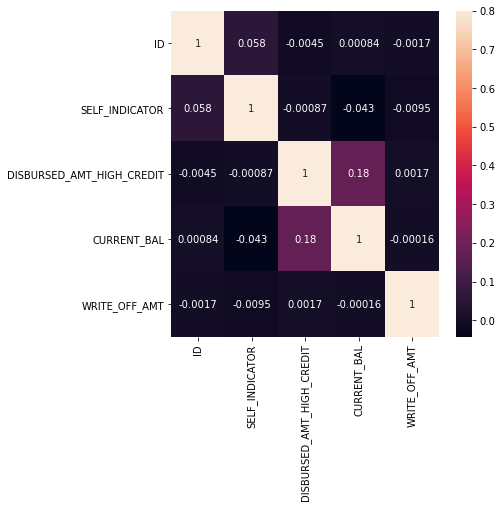

In [25]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
corrmat = bureau_Dataframe_pd.corr()
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corrmat, vmax=.8,annot = True)


<AxesSubplot:>

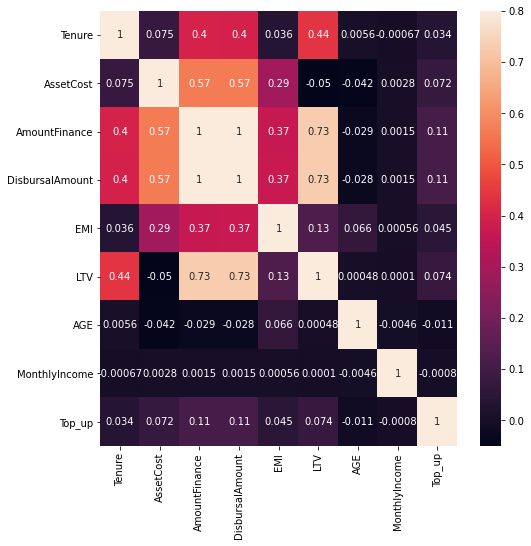

In [26]:
corrmat = customer_Dataframe_pd.corr()
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrmat, vmax=.8, annot = True)

these heatmap tells me that how features are relate to each other features. In bureau_Dataframe all features are weakly correlated, they are good. In customer_Dataframe, AmountFinance and DisbursalAmount have a correlation of 1, so they are same feature, will drop one of them. LTV is derived from AssetCost and AmountFinance, so I will keep LTV only but re-calculated

<AxesSubplot:title={'center':'bureau_Dataframe boxplot'}>

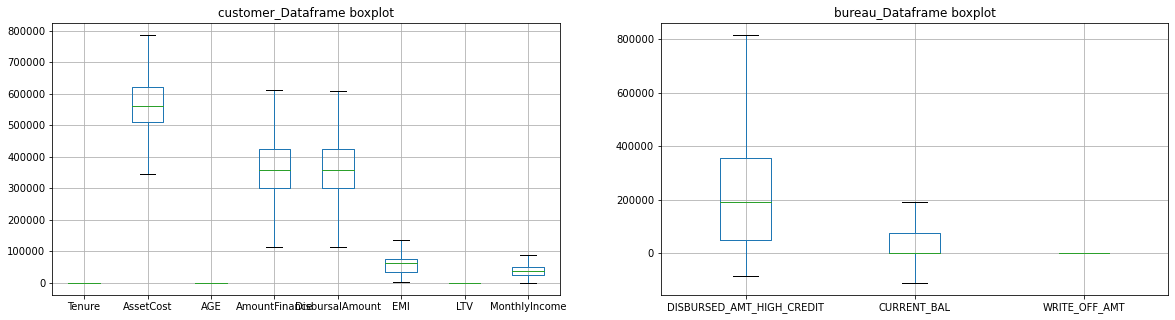

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(20, 5))
ax1.set_title('customer_Dataframe boxplot')
customer_Dataframe_pd.boxplot(column = numeric_type, showfliers=False,  ax = ax1)
ax2.set_title('bureau_Dataframe boxplot')
bureau_Dataframe_pd.boxplot(column = ['DISBURSED_AMT_HIGH_CREDIT','CURRENT_BAL', 'WRITE_OFF_AMT'], showfliers=False,ax = ax2)

From these boxplot, it tells mee that I need to do scaling on these numeric data, otherwise is hard to visualise them

On the other hand, vector machines or k-nearest neighbor algorithm cannot differentiate the significance of variable

<AxesSubplot:title={'center':'bureau_Dataframe boxplot'}>

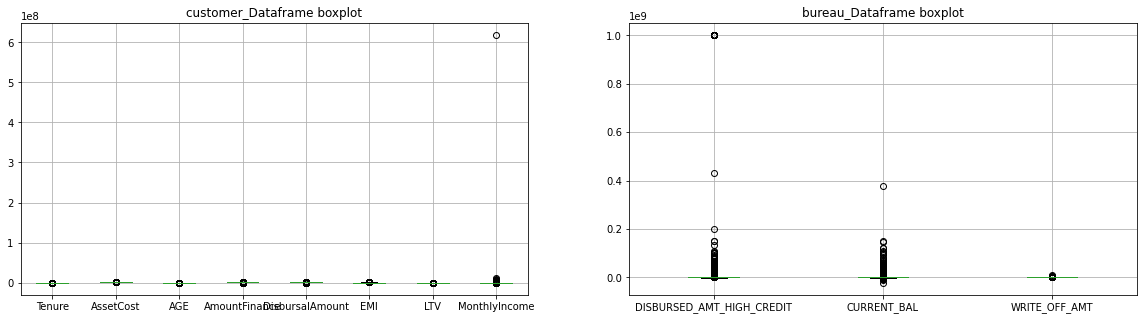

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(20, 5))
ax1.set_title('customer_Dataframe boxplot')
customer_Dataframe_pd.boxplot(column = numeric_type,  ax = ax1)
ax2.set_title('bureau_Dataframe boxplot')
bureau_Dataframe_pd.boxplot(column = ['DISBURSED_AMT_HIGH_CREDIT','CURRENT_BAL', 'WRITE_OFF_AMT'],ax = ax2)

And there are outliers or maybe wrong data need to be removed or scaled

For categorical values:

In [29]:
def plot(customer_feature):
    for feature in customer_feature:
        df0_pd = customer_Dataframe.select(feature,"TOP_up").groupBy(feature,"TOP_up").count().\
            filter("TOP_up == 0").toPandas()
        df1_pd = customer_Dataframe.select(feature,"TOP_up").groupBy(feature,"TOP_up").count().\
            filter("TOP_up == 1").toPandas()
        df0_pd.plot(kind = 'pie', y = 'count')
        df1_pd.plot(kind = 'pie', y = 'count')

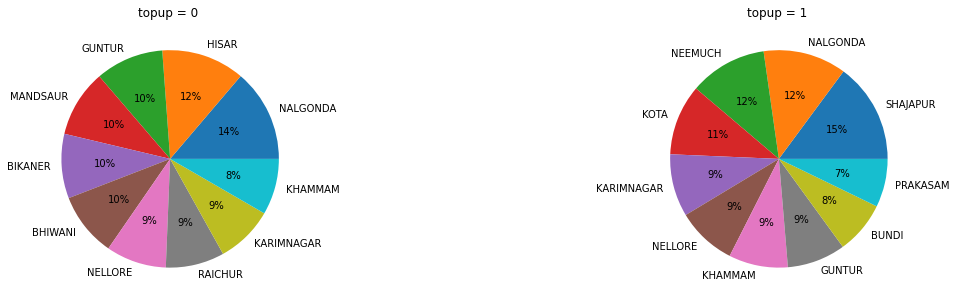

In [30]:
customer_feature = ['City']
for feature in customer_feature:
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(20, 5))
    df0_pd = customer_Dataframe.select(feature,"TOP_up").groupBy(feature,"TOP_up").count().\
        filter("TOP_up == 0").sort(col("count").desc()).limit(10).toPandas()
    df1_pd = customer_Dataframe.select(feature,"TOP_up").groupBy(feature,"TOP_up").count().\
        filter("TOP_up == 1").sort(col("count").desc()).limit(10).toPandas()
    ax1.pie(df0_pd['count'],labels = df0_pd['City'],autopct = "%.0f%%")
    ax1.set_title('topup = 0 ')
    ax2.pie(df1_pd['count'],labels = df1_pd['City'],autopct = "%.0f%%")
    ax2.set_title('topup = 1 ')


For people dont topup, 9% from Guntur. FOr people does topup, 9% from Guntur and so on. So whether people top up or not has little to do with where they come from. "CITY", "STATE", "ZIPCODE" are similar features, so will drop them all

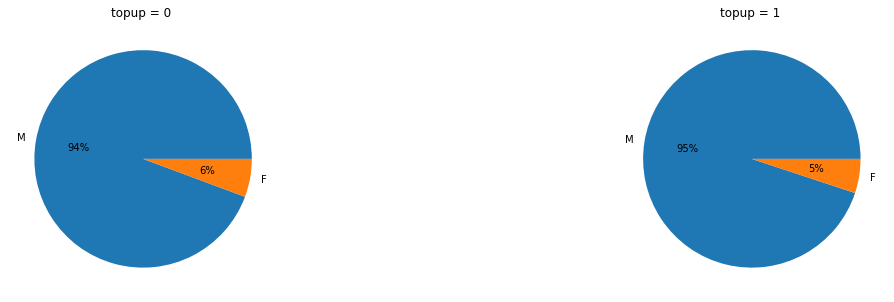

In [31]:
customer_feature = ['SEX']
for feature in customer_feature:
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(20, 5))
    df0_pd = customer_Dataframe.select(feature,"TOP_up").groupBy(feature,"TOP_up").count().\
        filter("TOP_up == 0").sort(col("count").desc()).limit(10).toPandas()
    df1_pd = customer_Dataframe.select(feature,"TOP_up").groupBy(feature,"TOP_up").count().\
        filter("TOP_up == 1").sort(col("count").desc()).limit(10).toPandas()
    ax1.pie(df0_pd['count'],labels = df0_pd['SEX'],autopct = "%.0f%%")
    ax1.set_title('topup = 0 ')
    ax2.pie(df1_pd['count'],labels = df1_pd['SEX'],autopct = "%.0f%%")
    ax2.set_title('topup = 1 ')

For people dont topup, 94% from Male. For people does topup, 95% from Male. So whether people top up or not has little to do with their sex, so will drop it

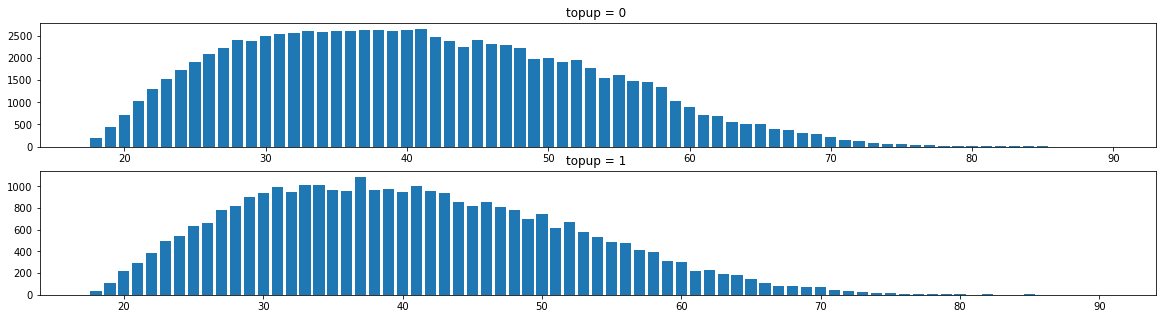

In [32]:
customer_feature = ["AGE"]
for feature in customer_feature:
    fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize =(20, 5))
    df0_pd = customer_Dataframe.select(feature,"TOP_up").groupBy(feature,"TOP_up").count().\
        filter("TOP_up == 0").sort(col("AGE").asc()).toPandas()
    df1_pd = customer_Dataframe.select(feature,"TOP_up").groupBy(feature,"TOP_up").count().\
        filter("TOP_up == 1").sort(col("AGE").asc()).toPandas()
    y0 = np.arange(len(df0_pd))
    y1 = np.arange(len(df1_pd))
    ax1.bar(df0_pd['AGE'], df0_pd['count'])
    ax1.set_title('topup = 0 ')
    ax2.bar(df1_pd['AGE'],df1_pd['count'])
    ax2.set_title('topup = 1 ')

It looks like old people are unlikely to top up

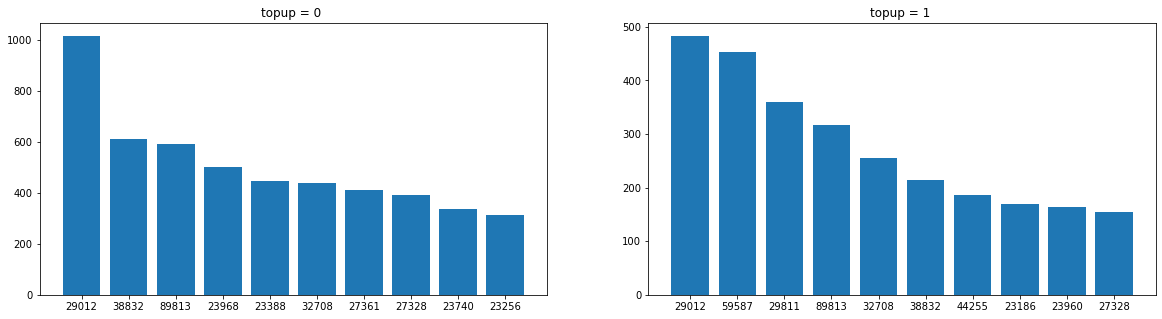

In [33]:
customer_feature = ['SupplierID']
for feature in customer_feature:
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(20, 5))
    df0_pd = customer_Dataframe.select(feature,"TOP_up").groupBy(feature,"TOP_up").count().\
        filter("TOP_up == 0").sort(col("count").desc()).limit(10).toPandas()
    df1_pd = customer_Dataframe.select(feature,"TOP_up").groupBy(feature,"TOP_up").count().\
        filter("TOP_up == 1").sort(col("count").desc()).limit(10).toPandas()
    y0 = np.arange(len(df0_pd))
    y1 = np.arange(len(df1_pd))
    ax1.bar(df0_pd['SupplierID'], df0_pd['count'])
    ax1.set_title('topup = 0 ')
    ax2.bar(df1_pd['SupplierID'],df1_pd['count'])
    ax2.set_title('topup = 1 ')

Top 10 topup and no top up supplier id are different, so it is a useful feature

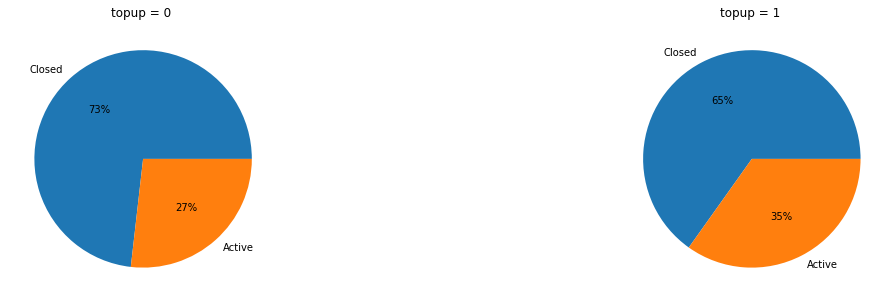

In [34]:
customer_feature = ['LoanStatus']
for feature in customer_feature:
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(20, 5))
    df0_pd = customer_Dataframe.select(feature,"TOP_up").groupBy(feature,"TOP_up").count().\
        filter("TOP_up == 0").sort(col("count").desc()).limit(10).toPandas()
    df1_pd = customer_Dataframe.select(feature,"TOP_up").groupBy(feature,"TOP_up").count().\
        filter("TOP_up == 1").sort(col("count").desc()).limit(10).toPandas()
    ax1.pie(df0_pd['count'],labels = df0_pd['LoanStatus'],autopct = "%.0f%%")
    ax1.set_title('topup = 0 ')
    ax2.pie(df1_pd['count'],labels = df1_pd['LoanStatus'],autopct = "%.0f%%")
    ax2.set_title('topup = 1 ')

For people dont topup, 73% from loanstatus = closed. For people does topup, 65%% from loanstatus = closed. So whether loanstatus = closed people is less likely to top up , so will keep this feature

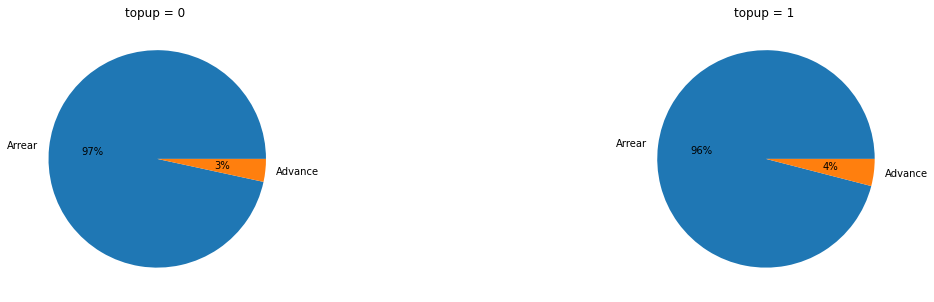

In [35]:
customer_feature = ['InstlmentMode']
for feature in customer_feature:
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(20, 5))
    df0_pd = customer_Dataframe.select(feature,"TOP_up").groupBy(feature,"TOP_up").count().\
        filter("TOP_up == 0").sort(col("count").desc()).limit(10).toPandas()
    df1_pd = customer_Dataframe.select(feature,"TOP_up").groupBy(feature,"TOP_up").count().\
        filter("TOP_up == 1").sort(col("count").desc()).limit(10).toPandas()
    ax1.pie(df0_pd['count'],labels = df0_pd['InstlmentMode'],autopct = "%.0f%%")
    ax1.set_title('topup = 0 ')
    ax2.pie(df1_pd['count'],labels = df1_pd['InstlmentMode'],autopct = "%.0f%%")
    ax2.set_title('topup = 1 ')

similar reason, will drop this feature

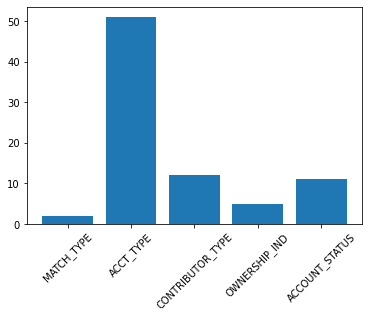

In [36]:
str_typeb = bureau_Dataframe[[item[0] for item in bureau_Dataframe.dtypes if item[1].startswith('str')]].columns
str_typec = customer_Dataframe[[item[0] for item in customer_Dataframe.dtypes if item[1].startswith('str')]].columns
df_b = bureau_Dataframe.agg(*(countDistinct(col(c)).alias(c) for c in str_typeb)).toPandas()
df_c = customer_Dataframe.agg(*(countDistinct(col(c)).alias(c) for c in str_typec)).toPandas()
plt.bar(df_b.columns.tolist(),df_b.iloc[0].tolist())
plt.xticks(rotation = 45)
plt.show()

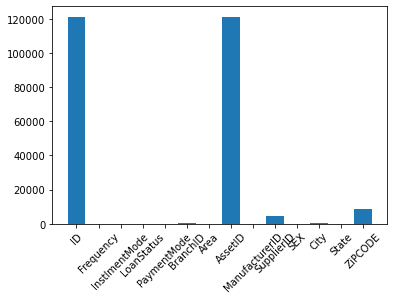

In [37]:
plt.bar(df_c.columns.tolist(),df_c.iloc[0].tolist())
plt.xticks(rotation = 45)
plt.show()

For some categorical feature, they have too many distinct values, these columns will burden the train process so I will drop them.

## Part2 Feature extraction and ML training <a class="anchor" id="task2"></a>

### 2.1 Preparing the training data and testing data <a class="anchor" id="task21"></a>

In [38]:
#drop features
df1 = bureau_Dataframe.drop("ACCT_TYPE","CONTRIBUTOR_TYPE","ACCOUNT_STATUS")
df2 = customer_Dataframe.drop("AssetCost","AmountFinance","DisbursalAmount","CITY","State",
                                       "ZiPCODE","DisbursalDate","MaturityDAte","PaymentMode","ManufacturerID",
                                       "SupplierID","SEX","BranchID","InstlmentMode","AuthDate","Area","AssetID")

In [39]:
#1. Randomly split the dataset into 80% training data and 20% testing data
# drop some 
#create sql tempview
df1.createOrReplaceTempView("df1")
df2.createOrReplaceTempView("df2")
#join data on ID
sql_inner = spark.sql('''
  SELECT s.*,c.*
  FROM df1 s INNER JOIN df2 c
  ON s.ID=c.ID
''')

sql_inner= sql_inner.drop("ID")
sql_inner = sql_inner.withColumn("TOP_up",col('TOP_up').cast(StringType()))
sql_inner.printSchema()

root
 |-- SELF_INDICATOR: boolean (nullable = true)
 |-- MATCH_TYPE: string (nullable = true)
 |-- OWNERSHIP_IND: string (nullable = true)
 |-- DISBURSED_AMT_HIGH_CREDIT: integer (nullable = true)
 |-- CURRENT_BAL: integer (nullable = true)
 |-- WRITE_OFF_AMT: double (nullable = true)
 |-- Frequency: string (nullable = true)
 |-- LoanStatus: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- EMI: double (nullable = true)
 |-- LTV: double (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- MonthlyIncome: double (nullable = true)
 |-- TOP_up: string (nullable = false)



In [40]:
# there are duplicate rows
sql_inner.groupBy(sql_inner.columns).count().filter("count>1").count()

23318

In [41]:
#drop duplicate rows
sql_inner = sql_inner.dropDuplicates()
sql_inner.groupBy(sql_inner.columns).count().filter("count>1").count()

0

In [42]:
#split dataset
train,test = sql_inner.randomSplit(weights = [0.8,0.2], seed = 123)

In [43]:
#2.Show the number of rows with different "Top-up" values of the training dataframe
print("number of top up = 0 rows:",train.filter("TOP_up==0").count())
print("number of top up = 1 rows:",train.filter("TOP_up==1").count())
total_rows = train.count()
#number of rows for rebalancing data:
nrow_rb = total_rows * 0.2
#number of rows for top up = 1
nrow_t = nrow_rb/3
nrow_nt = nrow_rb*2/3
# rebalance training data top-up vs non-top_up = 1:2
# split dataset by topup
train0 = train.filter("TOP_up == 0")
total_rows0 = train0.count()
train1 = train.filter("TOP_up == 1")
total_rows1 = train1.count()
#rebalancing
train0,test0 = train0.randomSplit(weights = [nrow_t/total_rows0,1-nrow_t/total_rows0], seed = 123)
train1,test1 = train1.randomSplit(weights = [nrow_nt/total_rows1,1-nrow_nt/total_rows1], seed = 123)
#merge
train_rebalance = train0.union(train1)
#shuffle
train_rebalance= train_rebalance.orderBy(rand())

number of top up = 0 rows: 249500
number of top up = 1 rows: 150735


In [44]:
print("training dataset / rebalanced dataset: ",train.count()/train_rebalance.count())
print("rebalance training data top-up vs non-top_up: ",train0.count()/train1.count())


training dataset / rebalanced dataset:  4.979100058470075
rebalance training data top-up vs non-top_up:  0.5042664361162275


In [45]:
train_rebalance.toPandas().head()

,SELF_INDICATOR,MATCH_TYPE,OWNERSHIP_IND,DISBURSED_AMT_HIGH_CREDIT,CURRENT_BAL,WRITE_OFF_AMT,Frequency,LoanStatus,Tenure,EMI,LTV,AGE,MonthlyIncome,TOP_up
0,True,PRIMARY,Individual,402355.0,0.0,0.0,Half Yearly,Closed,42,76200.0,75.21,35,37500.00,0
1,True,PRIMARY,Individual,43693.0,0.0,0.0,Half Yearly,Closed,48,70000.0,60.41,35,25000.00,1
2,False,PRIMARY,Individual,400000.0,288668.0,0.0,Monthly,Closed,36,52500.0,55.56,26,12500.00,1
3,True,PRIMARY,Individual,401954.0,190442.0,0.0,Quatrly,Active,36,43100.0,62.42,37,41666.67,1
4,False,PRIMARY,Individual,122000.0,0.0,0.0,Monthly,Closed,36,10677.0,52.74,37,41666.67,1


### 2.2 Preparing Features, Labels, and Models <a class="anchor" id="task22"></a>

**1.**

* Based on those plots and my summary, I will drop assetcost, amountfinance, disbursalamount, city,state ,zipcode, sex, instlmentmode, paymentmode, branchID acct_type, ID, manufactureID and assetID. And those datetime features in customer dataframe

* Some features are removed because they have so too many distinct values. If I use one hot encoding and the feature has 10000 distinct value, it will be 14 digits long binary number, which will increase calculation time significantly

* will keep the rest of features, but I should re-calculate LTV

* Definetly will scale the numerical data, for better visualization and so one feature does not over-weight others.  But first look at the data to see if they are normally distributed and if they are skewed, then I can choose the scaling method.

* For categorical data, I will consider age as numerical data, so rest of them are all non-ordinal relationship data. Therefore, I choose one hot enchoding

* after encoding, I can run a chi-square test between the label and categorical features to find the correlation
    

In [53]:
#2. Create Transformers/Estimators for transforming/assembling the features
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml import Transformer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier

In [64]:
sql_inner = sql_inner.withColumn("SELF_INDICATOR", col("SELF_INDICATOR").cast("string"))
sql_inner = sql_inner.withColumn("TOP_up", col("TOP_up").cast("integer"))

In [65]:
# Categorical columns without 'Frequency' as it's handled by the custom transformer
categorical_columns = ['SELF_INDICATOR', 'MATCH_TYPE', 'OWNERSHIP_IND', 'LoanStatus']

# Numerical columns
numerical_columns = ['DISBURSED_AMT_HIGH_CREDIT', 'CURRENT_BAL', 'WRITE_OFF_AMT', 'Tenure', 'EMI', 'LTV', 'AGE', 'MonthlyIncome' , 'TOP_up']


indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(sql_inner) for column in categorical_columns]
encoders = [OneHotEncoder(inputCol=column+"_index", outputCol=column+"_OHE") for column in categorical_columns]
assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders] + numerical_columns, outputCol="features")

# Build the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Fit the pipeline to training data
model = pipeline.fit(sql_inner)

# Transform the data
transformed_data = model.transform(sql_inner)

# Specify the target variable
target = 'TOP_up'

# Initialize the GBTClassifier
gbt = GBTClassifier(labelCol=target, featuresCol="features")

# Fit the model to the data
gbt_model = gbt.fit(transformed_data)

# Make predictions
predictions = gbt_model.transform(transformed_data)

Py4JJavaError: An error occurred while calling o2047.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 10 in stage 390.0 failed 1 times, most recent failure: Lost task 10.0 in stage 390.0 (TID 1938) (WIN-G02NS6TL57E.hub executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (VectorAssembler$$Lambda$6775/0x0000000801fb2c60: (struct<SELF_INDICATOR_OHE:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,MATCH_TYPE_OHE:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,OWNERSHIP_IND_OHE:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,LoanStatus_OHE:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,DISBURSED_AMT_HIGH_CREDIT_double_VectorAssembler_d57b18117b3a:double,CURRENT_BAL_double_VectorAssembler_d57b18117b3a:double,WRITE_OFF_AMT:double,Tenure_double_VectorAssembler_d57b18117b3a:double,EMI:double,LTV:double,AGE_double_VectorAssembler_d57b18117b3a:double,MonthlyIncome:double,TOP_up_double_VectorAssembler_d57b18117b3a:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:217)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.hashAgg_doAggregateWithKeysOutput_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1196)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2357)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 28 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2358)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$1(RDD.scala:1198)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.aggregate(RDD.scala:1191)
	at org.apache.spark.ml.tree.impl.DecisionTreeMetadata$.buildMetadata(DecisionTreeMetadata.scala:125)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.boost(GradientBoostedTrees.scala:333)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.run(GradientBoostedTrees.scala:61)
	at org.apache.spark.ml.classification.GBTClassifier.$anonfun$train$1(GBTClassifier.scala:201)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.GBTClassifier.train(GBTClassifier.scala:170)
	at org.apache.spark.ml.classification.GBTClassifier.train(GBTClassifier.scala:58)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (VectorAssembler$$Lambda$6775/0x0000000801fb2c60: (struct<SELF_INDICATOR_OHE:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,MATCH_TYPE_OHE:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,OWNERSHIP_IND_OHE:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,LoanStatus_OHE:struct<type:tinyint,size:int,indices:array<int>,values:array<double>>,DISBURSED_AMT_HIGH_CREDIT_double_VectorAssembler_d57b18117b3a:double,CURRENT_BAL_double_VectorAssembler_d57b18117b3a:double,WRITE_OFF_AMT:double,Tenure_double_VectorAssembler_d57b18117b3a:double,EMI:double,LTV:double,AGE_double_VectorAssembler_d57b18117b3a:double,MonthlyIncome:double,TOP_up_double_VectorAssembler_d57b18117b3a:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:217)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.hashAgg_doAggregateWithKeysOutput_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1196)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2357)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 28 more


In [52]:
#pipeline acts as an estimator,and consists of a sequence of stages
transfer_df = Pipeline(stages= combined_transform(categorical_columns,numerical_columns))

In [54]:
#model 1
decisionTree_arr = DecisionTreeClassifier(featuresCol='features',labelCol='binaryArrDelay', maxDepth=3)
#model 2
decisionTree_dep = DecisionTreeClassifier(featuresCol='features',labelCol='binaryDeptDelay',maxDepth=3)
#https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa
#model 3
gbt_arr = GBTClassifier(featuresCol= 'features',labelCol='binaryArrDelay',maxDepth=3)
#model 4
gbt_dep = GBTClassifier(featuresCol= 'features',labelCol='binaryDeptDelay',maxDepth=3)

In [55]:
from pyspark.ml.classification import NaiveBayes
#model 1
naiveBayes_arr = NaiveBayes(featuresCol='features',labelCol='multiClassArrDelay',smoothing = 1.0, modelType = 'multinomial')
#model 2
naiveBayes_dep = NaiveBayes(featuresCol='features',labelCol='multiCassDeptDelay',smoothing = 1.0, modelType = 'multinomial')

In [57]:
# Chain indexers and tree in a Pipeline
pipeline_arr =  Pipeline(stages= [combined_transform(categorical_columns,numerical_columns),decisionTree_arr])
pipeline_dep = Pipeline(stages= [combined_transform(categorical_columns,numerical_columns),decisionTree_dep])
pipeline_arr =  Pipeline(stages= [combined_transform(categorical_columns,numerical_columns),gbt_arr])
pipeline_dep = Pipeline(stages= [combined_transform(categorical_columns,numerical_columns),gbt_dep])
pipeline_arr =  Pipeline(stages= [combined_transform(categorical_columns,numerical_columns),naiveBayes_arr])
pipeline_dep = Pipeline(stages= [combined_transform(categorical_columns,numerical_columns),naiveBayes_dep])

### 2.3 Training and evaluating models  <a class="anchor" id="task23"></a>

In [58]:
def estimator_(pipeline_transformer,model_class,data,label_target):
    transformer = pipeline_transformer.fit(data)
    # 80% tain 20% test
    train,test = sql_inner.randomSplit(weights = [0.8,0.2], seed = 123)
    # transform tain data
    data_train = transformer.transform(train)
    # transform test data
    data_test = transformer.transform(test)
    # fit model 
    model_fit = model_class.fit(data_train)
    # get prediciton
    predictions_ = model_fit.transform(data_test)
    # group by 
    # 'prediction = 0 and label = 0'
    # 'prediction = 0 and label = 1'
    # 'prediction = 1 and label = 0'
    # 'prediction = 1 and label = 1'
    predictions_.groupBy(label_target,'prediction').count().show()
    return model_fit,predictions_

In [62]:
sql_inner = sql_inner.withColumn("SELF_INDICATOR", col("SELF_INDICATOR").cast("string"))

In [63]:
#model 1
print('predict arrival delay using descision tree(binary classification.')
Model_Dtree_arr,Predictions_Dtree_arr = estimator_(transfer_df,decisionTree_arr,sql_inner,'binaryArrDelay')

predict arrival delay using descision tree(binary classification.


IllegalArgumentException: binaryArrDelay does not exist. Available: SELF_INDICATOR, MATCH_TYPE, OWNERSHIP_IND, DISBURSED_AMT_HIGH_CREDIT, CURRENT_BAL, WRITE_OFF_AMT, Frequency, LoanStatus, Tenure, EMI, LTV, AGE, MonthlyIncome, TOP_up, SELF_INDICATOR_index, MATCH_TYPE_index, OWNERSHIP_IND_index, LoanStatus_index, SELF_INDICATOR_vec, MATCH_TYPE_vec, OWNERSHIP_IND_vec, LoanStatus_vec, features

## Part3 Knowledge sharing <a class="anchor" id="task3"></a>

In [126]:
from pyspark.ml.clustering import KMeans
#1
test_df = spark.createDataFrame([[0, 35.3, 37.5],
                                 [1, 41.4, -23.5],
                                 [2, 28.3, -13.3],
                                 [3, 09.5, -9.0],
                                 [4, 62.8, -18.23],
                                 [5, 63.8, -18.33],
                                 [6, 82.8, -17.23],
                                 [7, 52.8, -13.43],
                                 [8, 72.8, 48.23],
                                 [9, 65.8, 15.43],
                                 [10, 42.8, -13.23] ],
                                ["ID","Att_1", "Att_2"])
assembler = VectorAssembler(inputCols=["Att_1", "Att_2"],outputCol='features')
kmeans = KMeans(k=4).fit(assembler.transform(test_df))

In [3]:
from IPython.display import Image
  
# get the image, there are 16 jobs
Image(url="p1.png")

2

##### What method or what kmeans method is used to choose the initial center by default in spark?

it has two methods, either choose a random points as initial cluster centers or "k-means||" to use a parallel variant of k-means++

##### What will it do if it generates a number of centers more than 'k'?

weight each candidate by the number of points in the dataset mapping to it and run a local k-means++ on the weighted centers to pick k of them